In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from imvc.datasets import LoadDataset
from imvc.decomposition import jNMF
from imvc.preprocessing import MultiViewTransformer, ConcatenateViews, DropView
from imvc.ampute import Amputer
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from functools import reduce
from sklearn.preprocessing import FunctionTransformer
from imvc.feature_selection import jNMFFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})

In [17]:
Xs, y = LoadDataset.load_dataset(dataset_name="nutrimouse", return_y=True)

In [18]:
ps = np.arange(0.1, 1., 0.2)
n_components_list = [1, 2, 4, 8, 16, 32]
n_times = 50
all_metrics = {}

In [19]:
key = "jNMF"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism="PM", random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMF(n_components = n_components, random_state=i))
            try:
                transformed_X = pipeline.fit_transform(amputed_Xs)
                metric = np.mean([mean_squared_error(X.values[mask], np.dot(transformed_X + V, H.T)[mask]) 
                                  for X,V,H,mask in zip(pipeline[0].transform(Xs), pipeline[-1].V_, pipeline[-1].H_, masks)])
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

In [20]:
key = "Baseline"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism="PM", random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     MultiViewTransformer(SimpleImputer().set_output(transform="pandas")))
            try:
                transformed_Xs = pipeline.fit_transform(amputed_Xs)
                metric = np.mean([mean_squared_error(X.values[mask], transformed_X.values[mask]) 
                                  for X,transformed_X,mask in zip(pipeline[0].transform(Xs), transformed_Xs, masks)])
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

In [21]:
flattened_data = [
    {
        'Method': method,
        'Missing rate (\%)': p,
        'Components': n_comp,
        **n_dict
    }
    for method, method_dict in all_metrics.items()
    for p, p_dict in method_dict.items()
    for n_comp, n_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', 'Missing rate (\%)', "Components"], var_name='Iteration', value_name='Reconstruction error (MSE)')
df = df.sort_values(["Missing rate (\%)", "Method", "Components", "Iteration"], ascending=[True, False, True, True])
df.to_csv("tutorials/reduction_results.csv", index= None)
df

,Method,Missing rate (\%),Components,Iteration,Reconstruction error (MSE)
0,jNMF,10,1,0,0.076149
48,jNMF,10,1,1,0.061625
96,jNMF,10,1,2,0.057852
144,jNMF,10,1,3,0.064574
192,jNMF,10,1,4,0.067845
...,...,...,...,...,...
2207,Baseline,70,32,45,2.543549
2255,Baseline,70,32,46,NaN
2303,Baseline,70,32,47,NaN
2351,Baseline,70,32,48,NaN


In [22]:
df = pd.read_csv("tutorials/reduction_results.csv")
df

,Method,Missing rate (\%),Components,Iteration,Reconstruction error (MSE)
0,jNMF,10,1,0,0.076149
1,jNMF,10,1,1,0.061625
2,jNMF,10,1,2,0.057852
3,jNMF,10,1,3,0.064574
4,jNMF,10,1,4,0.067845
...,...,...,...,...,...
2395,Baseline,70,32,45,2.543549
2396,Baseline,70,32,46,NaN
2397,Baseline,70,32,47,NaN
2398,Baseline,70,32,48,NaN


In [23]:
diff_df = df.groupby(["Method", "Missing rate (\%)", "Components"]).mean()
diff_df = diff_df.groupby(["Method", "Missing rate (\%)"]).min() \
    .sort_values(["Method"], ascending=[False]) \
    .groupby(["Missing rate (\%)"]).agg({'Reconstruction error (MSE)': lambda L: reduce(np.divide, L)}) \
    .reset_index() \
    .merge(
        diff_df.loc[diff_df.groupby(["Method", "Missing rate (\%)"])["Reconstruction error (MSE)"].idxmin()] \
            .filter(like= "jNMF", axis= 0).reset_index()[["Missing rate (\%)"]])
diff_df["Reconstruction error (MSE) difference"] = 1 - diff_df["Reconstruction error (MSE)"]
diff_df = diff_df.drop(columns= "Reconstruction error (MSE)").round(3)
diff_df

,Missing rate (\%),Components,Reconstruction error (MSE) difference
0,10,32,0.082
1,30,1,0.044
2,50,1,0.013
3,70,16,0.006


In [10]:
print(diff_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Missing rate (\%) & Components & Reconstruction error (MSE) difference \\
\midrule
0 & 10 & 32 & 0.082000 \\
1 & 30 & 1 & 0.044000 \\
2 & 50 & 1 & 0.013000 \\
3 & 70 & 16 & 0.005000 \\
\bottomrule
\end{tabular}



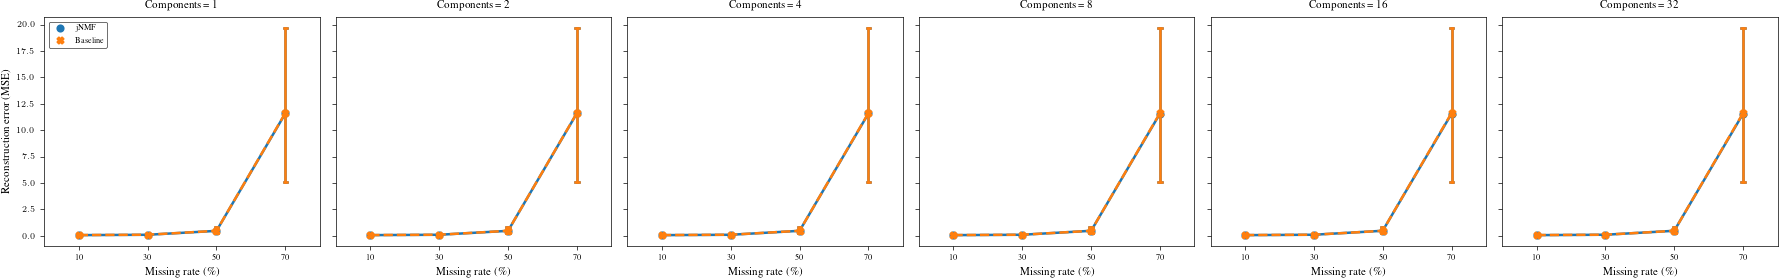

In [7]:
g = sns.FacetGrid(data=df, col="Components", despine=False).map_dataframe(sns.pointplot, x="Missing rate (\%)", y="Reconstruction error (MSE)", hue="Method", markers=["o", "X"], linestyles=["-", "--"], capsize= 0.05,
                                                           seed= 42, palette= "Set2_r")
g.axes[0][0].legend(loc='upper left')
plt.savefig("paper_figures/reduction_a.pdf")
plt.savefig("paper_figures/reduction_a.svg")

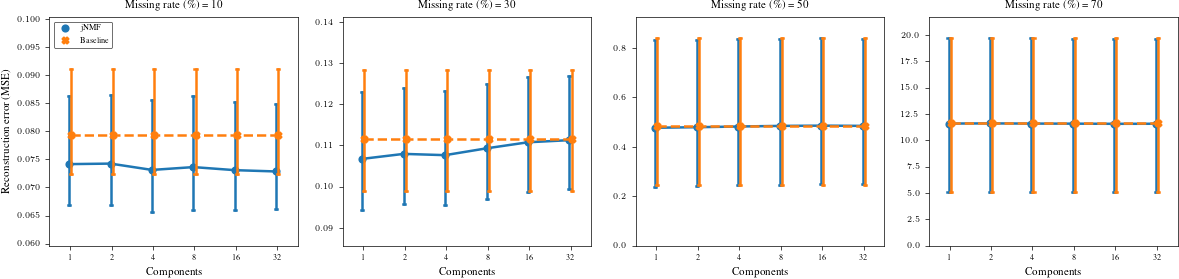

In [8]:
g = sns.FacetGrid(data=df, col="Missing rate (\%)", despine=False, sharey=False).map_dataframe(sns.pointplot, x="Components", y="Reconstruction error (MSE)", hue="Method", markers=["o", "X"], linestyles=["-", "--"], capsize= 0.05,
                                                           seed= 42, palette= "Set2_r", dodge=True)
g.axes[0][0].legend(loc='upper left')
for ax in g.axes[0]:
    values = [j for i in ax.lines for j in i.get_ydata()]
    if any(np.array(values)> 0.5):
        min_y = 0
        max_y = max(values) * 1.1
    else:
        min_y = min(values) / 1.1
        max_y = max(values) * 1.1
    ax.set_ylim((min_y, max_y))
plt.savefig("paper_figures/reduction_b.pdf")
plt.savefig("paper_figures/reduction_b.svg")

In [6]:
y = y.iloc[:,0]
y.value_counts()

genotype
1    20
0    20
Name: count, dtype: int64

In [48]:
ps = np.arange(0, 0.9, 0.2)
n_components_list = [1, 2, 4, 8, 16, 32]
n_times = 50
all_metrics = {}

In [49]:
key = "jNMF"
all_metrics[key] = {}
sss = StratifiedShuffleSplit(n_splits=n_times, test_size=0.2, random_state=42)
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism="PM", random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMF(n_components = n_components, random_state=i),
                                     )
            transformed_X = pipeline.fit_transform(Xs_train)
            preds = SVC(random_state=i).fit(transformed_X, y_train).predict(transformed_X)
            try:
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

In [50]:
key = "jNMFFS"
all_metrics[key] = {}
sss = StratifiedShuffleSplit(n_splits=n_times, test_size=0.2, random_state=42)
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism="PM", random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMFFeatureSelector(n_components = n_components, random_state=i),
                                     FunctionTransformer(lambda x: np.concatenate(x, axis=1)),
                                     SimpleImputer(),
                                     )
            transformed_X = pipeline.fit_transform(Xs_train)
            preds = SVC(random_state=i).fit(transformed_X, y_train).predict(transformed_X)
            try:
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

In [51]:
key = "Baseline"
all_metrics[key] = {}
sss = StratifiedShuffleSplit(n_splits=n_times, test_size=0.2, random_state=42)
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism="PM", random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     ConcatenateViews(),
                                     FunctionTransformer(lambda x: x.iloc[:,np.random.default_rng(i).integers(0, 141, size= n_components)]),
                                     SimpleImputer())
            try:
                transformed_X = pipeline.fit_transform(Xs_train)
                preds = SVC(random_state=i).fit(transformed_X, y_train).predict(transformed_X)
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

In [52]:
flattened_data = [
    {
        'Method': method,
        'Missing rate (\%)': p,
        'Components': n_comp,
        **n_dict
    }
    for method, method_dict in all_metrics.items()
    for p, p_dict in method_dict.items()
    for n_comp, n_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', 'Missing rate (\%)', "Components"], var_name='Iteration',
             value_name='Accuracy')
df = df.sort_values(["Missing rate (\%)", "Method", "Components", "Iteration"], ascending=[True, False, True, True])
df.to_csv("tutorials/selection_results.csv", index= None)
df

,Method,Missing rate (\%),Components,Iteration,Accuracy
30,jNMFFS,0,1,0,0.68750
120,jNMFFS,0,1,1,0.78125
210,jNMFFS,0,1,2,0.75000
300,jNMFFS,0,1,3,0.78125
390,jNMFFS,0,1,4,0.93750
...,...,...,...,...,...
4139,Baseline,80,32,45,0.93750
4229,Baseline,80,32,46,0.93750
4319,Baseline,80,32,47,0.68750
4409,Baseline,80,32,48,0.65625


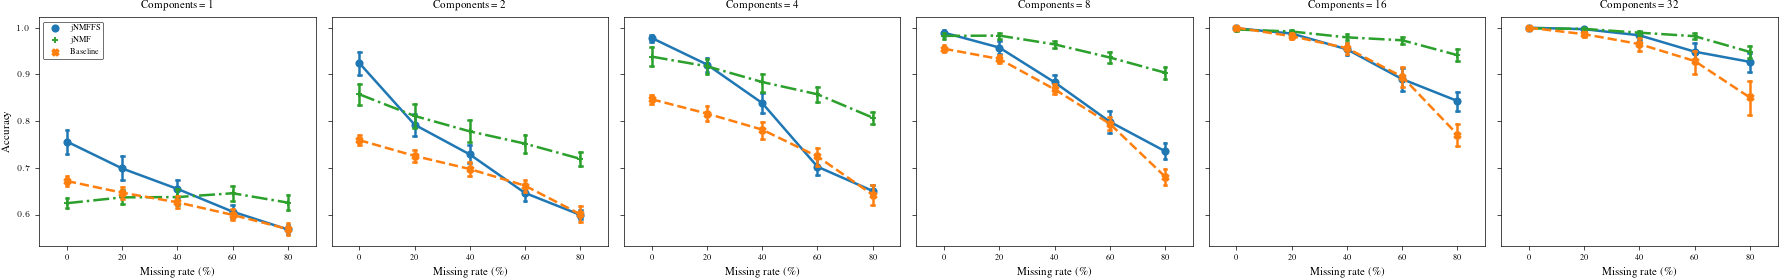

In [53]:
g = sns.FacetGrid(data=df, col="Components", despine=False).map_dataframe(sns.pointplot, x="Missing rate (\%)", y="Accuracy", hue="Method",
                                                                          markers=["o", "+", "X"], linestyles=["-", "-.", "--"], capsize= 0.05, 
                                                                          seed= 42, palette= ["#1f77b4", "#2ca02c", "#ff7f0e"])
g.axes[0][0].legend(loc='upper left')
plt.savefig("paper_figures/selection_a.pdf")
plt.savefig("paper_figures/selection_a.svg")

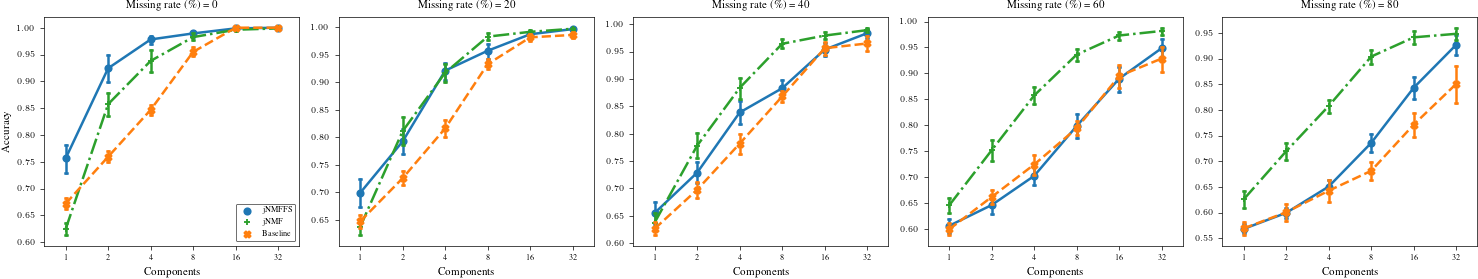

In [54]:
g = sns.FacetGrid(data=df, col="Missing rate (\%)", despine=False, sharey=False).map_dataframe(sns.pointplot, x="Components", y="Accuracy", hue="Method",
                                                                                               markers=["o", "+", "X"], linestyles=["-", "-.", "--"],
                                                                                               capsize= 0.05,
                                                                                               seed= 42, palette= ["#1f77b4", "#2ca02c", "#ff7f0e"])
g.axes[0][0].legend(loc='lower right')
plt.savefig("paper_figures/selection_b.pdf")
plt.savefig("paper_figures/selection_b.svg")

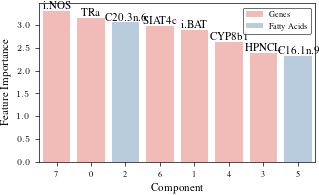

In [11]:
p = 0.3
amputed_Xs = Amputer(p= p, mechanism="PM", random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(42).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                         jNMF(n_components = 8, random_state=42).set_output(transform="pandas"))
transformed_Xs = pipeline.fit(amputed_Xs)
hs = pipeline[-1].H_
hs = pd.concat(hs, axis= 0).abs()
selected_features = {}
for col in hs:
    selected_features[hs[col].idxmax()] = hs[col].max()
selected_features = pd.Series(selected_features).reset_index().sort_values(by=0, ascending= False)
color_df = selected_features["index"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found")).to_frame("view")
colors = {color: colormaps["Pastel1"].colors[i] for i,color in enumerate(color_df["view"].unique())}
color_df["color"] = color_df["view"].apply(lambda x: colors[x])
components_to_plot = selected_features[0]
color_df["Feature Importance"] = components_to_plot
color_df["Name"] = selected_features["index"]
color_df = color_df.reset_index(names= "Component")
ax = sns.barplot(data=color_df, x="Component", y="Feature Importance", hue="view", order= color_df["Component"], dodge= False, palette="Pastel1")
ax.legend(title= None)
for container in ax.containers:
    ax.bar_label(container, labels=color_df["Name"])
plt.savefig("paper_figures/selection.pdf")
plt.savefig("paper_figures/selection.svg")